<a href="https://colab.research.google.com/github/lahmuller/CS_Notes/blob/main/Notes/deep_learning_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# numpy深度学习

100


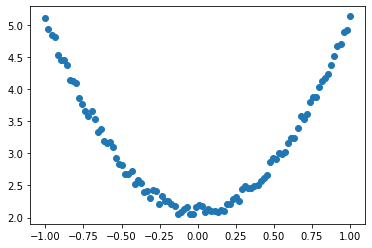

In [ ]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
np.random.seed(100)
x=np.linspace(-1,1,100).reshape(100,1)
print(x.size)
y=3*np.power(x,2)+2+0.2*np.random.rand(x.size).reshape(100,1)
plt.scatter(x,y)
plt.show()

In [ ]:
w1=np.random.rand(1,1)
b1=np.random.rand(1,1)
lr=0.001
for i in range(800):
  y_pred=np.power(x,2)*w1+b1
  loss=0.5*(y_pred-y)**2
  loss=loss.sum()
  #grad
  grad_w=np.sum((y_pred-y)*np.power(x,2))
  grad_b=np.sum(y_pred-y)
  w1-=lr*grad_w
  b1-=lr*grad_b

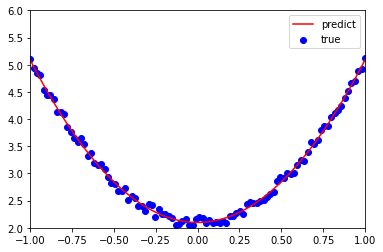

[[2.98927619]] [[2.09818307]]


In [ ]:
plt.plot(x,y_pred,'r-',label='predict')
plt.scatter(x,y,color='blue',marker='o',label='true')
plt.xlim(-1,1)
plt.ylim(2,6)
plt.legend()
plt.show()
print(w1,b1)



---



# pytorch深度学习

## a simple one

In [ ]:
import torch as t
%matplotlib inline
from matplotlib import pyplot as plt

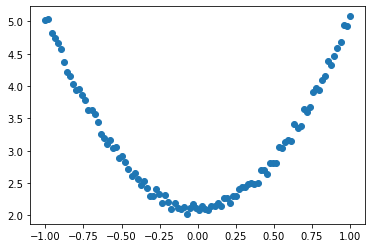

In [ ]:
t.manual_seed(100)
dtype=t.float
x=t.unsqueeze(t.linspace(-1,1,100),dim=1)
y=3*x.pow(2)+2+0.2*t.rand(x.size())
plt.scatter(x.numpy(),y.numpy())
plt.show()

In [ ]:
lr=0.001
w=t.rand(1,1,dtype=dtype,requires_grad=True)
b=t.rand(1,1,dtype=dtype,requires_grad=True)
for ii in range(800):
  y_pred=x.pow(2)*w+b
  loss=0.5*(y_pred-y)**2
  loss=loss.sum()
  #autograd
  loss.backward()
  #手动更新参数，需要用torch.no_grad()切断上下文自动求导的计算,此时不会track 对参数的计算（https://blog.csdn.net/weixin_46559271/article/details/105658654）
  with t.no_grad():
    w-=lr*w.grad
    b-=lr*b.grad
    #清零
    w.grad.data.zero_()
    b.grad.data.zero_()

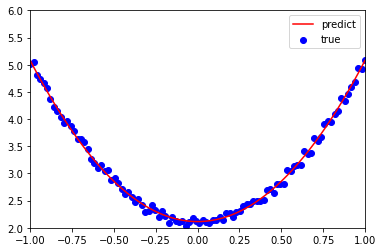

tensor([[2.9648]], requires_grad=True) tensor([[2.1146]], requires_grad=True)


In [ ]:
plt.plot(x.numpy(),y_pred.detach().numpy(),'r-',label='predict')
plt.scatter(x.numpy(),y.numpy(),color='blue',marker='o',label='true')
plt.xlim(-1,1)
plt.ylim(2,6)
plt.legend()
plt.show()
print(w,b)

## Loss

### CrossEntropyLoss()
> torch.nn.CrossEntropyLoss(weight: Optional[torch.Tensor] = None, size_average=None, ignore_index: int = -100, reduce=None, reduction: str = 'mean')
>
* This CrossEntropyLoss is different to [cross entropy](https://zhuanlan.zhihu.com/p/98785902), which is caculated with 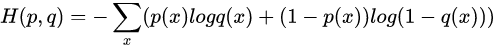
* This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.


## Optimizer

In [10]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# hyper parameters
LR=0.01
BATCH_SIZE=32
EPOCH=12
# generate training data
# torch.unsqueeze() turns 1-D into 2_D, torch can only handle 2-D data
x=torch.unsqueeze(torch.linspace(-1,1,1000),dim=1)
y=x.pow(2)+0.1*torch.normal(torch.zeros(*x.size()))# normal distribution whose mean and standard deviation are given

torch_dataset=Data.TensorDataset(x,y)
loader=Data.DataLoader(dataset=torch_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [11]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.hidden=torch.nn.Linear(1,20)
    self.predict=torch.nn.Linear(20,1)
  def forward(self,x):
    x=F.relu(self.hidden(x))
    x=self.predict(x)
    return x

In [12]:
# multiple optimizers
net_SGD=Net()
net_Momentum=Net()
net_RMSProp=Net()
net_Adam=Net()
nets=[net_SGD,net_Momentum,net_RMSProp,net_Adam]

opt_SGD=torch.optim.SGD(net_SGD.parameters(),lr=LR)
opt_Momentum=torch.optim.SGD(net_Momentum.parameters(),lr=LR,momentum=0.9)
opt_RMSProp=torch.optim.RMSprop(net_RMSProp.parameters(),lr=LR,alpha=0.9)
opt_Adam=torch.optim.Adam(net_Adam.parameters(),lr=LR,betas=(0.9,0.99))
optimizers=[opt_SGD,opt_Momentum,opt_RMSProp,opt_Adam]

In [13]:
loss_func=torch.nn.MSELoss()
loss_his=[[],[],[],[]]
for epoch in range(EPOCH):
  for step,(batch_x,batch_y) in enumerate(loader):
    for net,opt,l_his in zip(nets,optimizers,loss_his):
      output=net(batch_x) # get output for every net
      loss=loss_func(output,batch_y)
      opt.zero_grad()
      loss.backward()
      opt.step()
      l_his.append(loss.data.numpy())
labels=['SGD','Momentum','RMSProp','Adam']

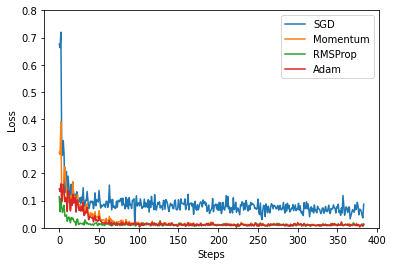

In [16]:
for i,l_his in enumerate(loss_his):
  plt.plot(l_his,label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0,0.8))
plt.show()

## utils

### DataLoader
* DataLoader: combines a dataset and a sampler, and provides an iterable over the given dataset.
> torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
batch_sampler=None, num_workers=0, collate_fn=None,
pin_memory=False, drop_last=False, timeout=0,
worker_init_fn=None)
* There are two types of dataset: map-style datasets, iterable-style datasets.
  1. map-style dataset is a class which has two constructor funtions: **\_\_getitem()\_\_** and **\_\_len()\_\_**.

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
 
class My_dataset(Dataset):# map-style
  def __init__(self):
    super().__init__()
    # 使用sin函数返回10个时间序列,如果不自己构造数据，就使用numpy,pandas等读取自己的数据为x即可。
    # 以下数据组织这块既可以放在init方法里，也可以放在getitem方法里
    self.x = torch.randn(10,3)
    self.y = self.x.sum(axis=1)
    self.src,  self.trg = [], []
    for i in range(10):
      self.src.append(self.x[i])# src=[tensor(...),tensor(...),...]
      self.trg.append(self.y[i])
          
  def __getitem__(self, index):
    return self.src[index], self.trg[index]

  def __len__(self):
    return len(self.src) 
        
 # 或者return len(self.trg), src和trg长度一样
 
data_train = My_dataset()
data_test = My_dataset()
data_loader_train = DataLoader(data_train, batch_size=5, shuffle=False)
data_loader_test = DataLoader(data_test, batch_size=5, shuffle=False)
# i_batch的多少根据batch size和def __len__(self)返回的长度确定
# batch_data返回的值根据def __getitem__(self, index)来确定
# 对训练集：(不太清楚enumerate返回什么的时候就多print试试)
for i_batch, batch_data in enumerate(data_loader_train):
    print(i_batch)  # 打印batch编号
    print(batch_data[0])  # 打印该batch里面src
    print(batch_data[1])  # 打印该batch里面trg
# 对测试集：（下面的语句也可以）
for i_batch, (src, trg) in enumerate(data_loader_test):
    print(i_batch)  # 打印batch编号
    print(src)  # 打印该batch里面src的尺寸
    print(trg)  # 打印该batch里面trg的尺寸    


0
tensor([[ 0.7777, -0.3005,  0.7759],
        [-0.1943, -0.4988,  1.0211],
        [-0.9013,  1.2346,  0.7615],
        [ 0.2182,  0.2124, -0.3363],
        [ 0.1835,  0.0992,  0.6933]])
tensor([1.2531, 0.3280, 1.0949, 0.0942, 0.9760])
1
tensor([[-0.1419, -0.4066,  2.1445],
        [-1.0576, -0.1036, -2.1420],
        [-0.0234, -0.2902,  0.4168],
        [-1.4408,  1.0976, -0.4800],
        [ 3.8838,  0.6355,  0.0686]])
tensor([ 1.5960, -3.3032,  0.1032, -0.8232,  4.5880])
0
tensor([[ 0.3913, -0.2867, -0.3659],
        [ 0.0114,  1.4702,  1.3827],
        [ 0.2079, -0.6564, -0.1896],
        [ 0.9922, -1.3462,  0.5770],
        [-0.2942, -0.2180,  1.6384]])
tensor([-0.2612,  2.8642, -0.6382,  0.2230,  1.1263])
1
tensor([[ 0.7523, -1.2070,  0.5562],
        [ 0.2840, -1.5392, -0.9443],
        [ 0.3075,  1.3998,  1.1748],
        [ 0.7228,  1.2405,  0.3971],
        [ 1.5699, -0.1896, -2.3072]])
tensor([ 0.1015, -2.1995,  2.8820,  2.3605, -0.9269])


or we can also resort to TensorDataset

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
 
src = torch.sin(torch.arange(1, 4, 0.1))
trg = torch.cos(torch.arange(1, 4, 0.1))
 
data = TensorDataset(src, trg)
data_loader = DataLoader(data, batch_size=5, shuffle=False)
for i_batch, batch_data in enumerate(data_loader):
    print(i_batch)  # 打印batch编号
    print(batch_data[0])  # 打印该batch里面src
    print(batch_data[1])  # 打印该batch里面trg


0
tensor([0.8415, 0.8912, 0.9320, 0.9636, 0.9854])
tensor([0.5403, 0.4536, 0.3624, 0.2675, 0.1700])
1
tensor([0.9975, 0.9996, 0.9917, 0.9738, 0.9463])
tensor([ 0.0707, -0.0292, -0.1288, -0.2272, -0.3233])
2
tensor([0.9093, 0.8632, 0.8085, 0.7457, 0.6755])
tensor([-0.4161, -0.5048, -0.5885, -0.6663, -0.7374])
3
tensor([0.5985, 0.5155, 0.4274, 0.3350, 0.2392])
tensor([-0.8011, -0.8569, -0.9041, -0.9422, -0.9710])
4
tensor([ 0.1411,  0.0416, -0.0584, -0.1577, -0.2555])
tensor([-0.9900, -0.9991, -0.9983, -0.9875, -0.9668])
5
tensor([-0.3508, -0.4425, -0.5298, -0.6119, -0.6878])
tensor([-0.9365, -0.8968, -0.8481, -0.7910, -0.7259])


对于一些数据集，每一份数据都在一份文件夹中，则可根据地址读取法，以读取lfw（labeled face in the wild)数据集为例

In [ ]:
import os

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.image as mpimg

# 对所有图片生成path-label map.txt 这个程序可根据实际需要适当修改
def generate_map(root_dir):
	#得到当前绝对路径
    current_path = os.path.abspath('.')
    #os.path.dirname()向前退一个路径
    father_path = os.path.abspath(os.path.dirname(current_path) + os.path.sep + ".")

    with open(root_dir + 'map.txt', 'w') as wfp:
        for idx in range(10):
            subdir = os.path.join(root_dir, '%d/' % idx)
            for file_name in os.listdir(subdir):
                abs_name = os.path.join(father_path, subdir, file_name)
                # linux_abs_name = abs_name.replace("\\", '/')
                wfp.write('{file_dir} {label}\n'.format(file_dir=linux_abs_name, label=idx))

# 实现MyDatasets类
class MyDatasets(Dataset):

    def __init__(self, dir):
        # 获取数据存放的dir
        # 例如d:/images/
        self.data_dir = dir
        # 用于存放(image,label) tuple的list,存放的数据例如(d:/image/1.png,4)
        self.image_target_list = []
        # 从dir--label的map文件中将所有的tuple对读取到image_target_list中
        # map.txt中全部存放的是d:/.../image_data/1/3.jpg 1 路径最好是绝对路径
        with open(os.path.join(dir, 'map.txt'), 'r') as fp:
            content = fp.readlines()
            #s.rstrip()删除字符串末尾指定字符（默认是字符）
            # 得到 [['d:/.../image_data/1/3.jpg', '1'], ...,]
            str_list = [s.rstrip().split() for s in content]
            # 将所有图片的dir--label对都放入列表，如果要执行多个epoch，可以在这里多复制几遍，然后统一shuffle比较好
            self.image_target_list = [(x[0], int(x[1])) for x in str_list]

    def __getitem__(self, index):
        image_label_pair = self.image_target_list[index]
        # 按path读取图片数据，并转换为图片格式例如[3,32,32]
        # 可以用别的代替
        img = mpimg.imread(image_label_pair[0])
        return img, image_label_pair[1]

    def __len__(self):
        return len(self.image_target_list)


if __name__ == '__main__':
    # 生成map.txt
    # generate_map('train/')

    train_loader = DataLoader(MyDatasets('train/'), batch_size=128, shuffle=True)

    for step in range(20000):
        for idx, (img, label) in enumerate(train_loader):
            print(img.shape)
            print(label.shape)



## torchvision
> There are four modules in torchvision: model, datasets, transforms and utils.

### transforms
* transforms accepts PILImage,Tensor Image or batch of Tensor Images as input.
* These image transformations can be chained together using compose.

In [ ]:
transforms.Compose([
    #centercrop
    #size could be a tuple (height,width)
    #size could also be a integer, square in this circumstance
    transforms.CenterCrop(10),
    # the center is random chosen
    transforms.RandomCrop(20,padding=0),
    tranforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

## MNIST

### Preprocess



1.   transforms.Compose() can bind the transforms function together
2.   Normalize([0.5],[0.5])对张量进行归一化，这里两个0.5分别表示对张量进行归一化的全局平均值和方差。因为图像是灰色的只有一个通道，如果有多个通道，则需要多个数字，如3个通道，应该是Normalize([m1,m2,m3])






In [ ]:
import numpy as np
import torch
from torchvision.datasets import mnist
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [ ]:
# define hyperparameters
train_batch_size=64
test_batch_size=128
learning_rate=0.01
num_epoches=20
lr=0.01
momentum=0.5

In [ ]:
# define the function
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])
# download the data and do the preprocess
train_dataset=mnist.MNIST('./data',train=True,transform=transform,download=True)
test_dataset=mnist.MNIST('./data',train=False,transform=transform)
# dataLoader is an iterable object
train_loader=DataLoader(train_dataset,batch_size=train_batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=test_batch_size,shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


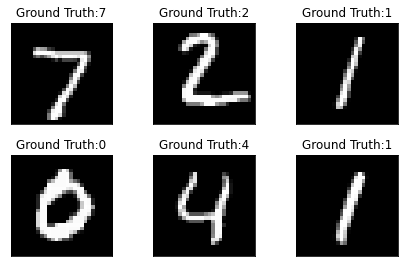

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

examples=enumerate(test_loader)
batch_idx,(example_data,example_targets)=next(examples)
fig=plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)# 2*3, i+1 is the index of image starting from 1
  plt.tight_layout()
  plt.imshow(example_data[i][0],cmap='gray',interpolation='none')#
  plt.title("Ground Truth:{}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

### build the model

In [ ]:
class Net(nn.Module):
  """
  use sequential to build the net, Sequential() combine the layers
  """
  def __init__(self,in_dim,n_hidden_1,n_hidden_2,out_dim):
    super(Net,self).__init__()
    self.layer1=nn.Sequential(nn.Linear(in_dim,n_hidden_1),nn.BatchNorm1d(n_hidden_1))
    self.layer2=nn.Sequential(nn.Linear(n_hidden_1,n_hidden_2),nn.BatchNorm1d(n_hidden_2))
    self.layer3=nn.Sequential(nn.Linear(n_hidden_2,out_dim))
  
  def forward(self,x):
    x=F.relu(self.layer1(x))
    x=F.relu(self.layer2(x))
    x=self.layer3(x)
    return x

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# instantiate the net
model=Net(28*28,300,100,10)
model.to(device)

# define the loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=lr,momentum=momentum)

In [ ]:
a=torch.randn(128,10)
l=criterion(a,example_targets)
print(l)

tensor(2.7076)


In [ ]:
print(len(optimizer.param_groups))# a list
print(len(optimizer.param_groups[0]))# a dict

1
6


### Train the model

In [ ]:
losses=[]
acces=[]
eval_losses=[]
eval_acces=[]

for epoch in range(num_epoches):
  train_loss=0
  train_acc=0
  model.train()
# change the learning rate dynamically
  if epoch%5==0:
    optimizer.param_groups[0]['lr']*=0.1
  for img,label in train_loader:
    img=img.to(device)
    label=label.to(device)
    #img.size()=[64,1,28,28]
    #label.size()=[64]
    img=img.view(img.size(0),-1)#img.size()=[64,28*28]
    # forward
    out=model(img)#out.size()=[64,10]
    loss=criterion(out,label)#loss.size()=[1]
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # record the difference
    train_loss+=loss.item()
    # caculate the accuracy
    _,pred=out.max(1)# predict the one with the maximum probability
    num_correct=(pred==label).sum().item()
    acc=num_correct/img.shape[0]
    train_acc+=acc
  
  losses.append(train_loss/len(train_loader))
  acces.append(train_acc/len(train_loader))
  # test on test data
  eval_loss=0
  eval_acc=0
# change the model into predict model
  model.eval()
  for img,label in test_loader:
    img=img.to(device)
    label=label.to(device)
    img=img.view(img.size(0),-1)
    out=model(img)
    loss=criterion(out,label)
    # record the loss
    eval_loss+=loss.item()
    # record the acc
    _,pred=out.max(1)
    num_correct=(pred==label).sum().item()
    acc=num_correct/img.shape[0]
    eval_acc+=acc
  eval_losses.append(eval_loss/len(test_loader))
  eval_acces.append(eval_acc/len(test_loader))
  print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
      .format(epoch,train_loss/len(train_loader),train_acc/len(train_loader),eval_loss/len(test_loader),eval_acc/len(test_loader)))

epoch: 0, Train Loss: 1.0448, Train Acc: 0.7683, Test Loss: 0.5702, Test Acc: 0.8930
epoch: 1, Train Loss: 0.4921, Train Acc: 0.8969, Test Loss: 0.3639, Test Acc: 0.9215
epoch: 2, Train Loss: 0.3549, Train Acc: 0.9181, Test Loss: 0.2777, Test Acc: 0.9381
epoch: 3, Train Loss: 0.2855, Train Acc: 0.9330, Test Loss: 0.2284, Test Acc: 0.9455
epoch: 4, Train Loss: 0.2437, Train Acc: 0.9400, Test Loss: 0.1998, Test Acc: 0.9524
epoch: 5, Train Loss: 0.2222, Train Acc: 0.9461, Test Loss: 0.1951, Test Acc: 0.9517
epoch: 6, Train Loss: 0.2214, Train Acc: 0.9461, Test Loss: 0.1929, Test Acc: 0.9531
epoch: 7, Train Loss: 0.2183, Train Acc: 0.9468, Test Loss: 0.1915, Test Acc: 0.9527
epoch: 8, Train Loss: 0.2136, Train Acc: 0.9475, Test Loss: 0.1884, Test Acc: 0.9531
epoch: 9, Train Loss: 0.2131, Train Acc: 0.9472, Test Loss: 0.1867, Test Acc: 0.9535
epoch: 10, Train Loss: 0.2093, Train Acc: 0.9493, Test Loss: 0.1873, Test Acc: 0.9542
epoch: 11, Train Loss: 0.2114, Train Acc: 0.9485, Test Loss: 0.1